In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark/detection/detector_eval')

In [3]:
import json
import os
from collections import defaultdict

from detection.detector_eval import detector_eval
from data_management import cct_json_utils
from visualization.visualization_utils import plot_precision_recall_curve

In [4]:
detection_results_dir = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904'
results_path = [os.path.join(detection_results_dir, f) for f in os.listdir(detection_results_dir)]

In [5]:
results_path

['/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/5618_detections_train_cct_20_val_ss1_20190908093215.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/6704_detections_train_ss1_val_cct20_20190908092921.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/8506_detections_train_cct_20_val_cct20_20190908093026.json',
 '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/948_detections_train_ss1_val_ss1_20190908092426.json']

In [6]:
num_gt_classes = 2

Ground truth: `[x, y, width, height]`
    
API output: `[x_min, y_min, width_of_box, height_of_box]`

TF format: `[y_min, x_min, y_max, x_max]`

In [7]:
def make_detection_res(results_path, file_prefix=''):
    with open(results_path) as f:
        res = json.load(f)
    
    detection_res = {}

    for i in res['images']:
        file_name = i['file'].split(file_prefix)[1].split('.jpg')[0].split('.JPG')[0]
        detection_res[file_name] = i  # all detections on that image is in this dict
    return detection_res

In [12]:
def get_gt_db(gt_db_path):
    with open(gt_db_path) as f:
        gt_db = json.load(f)
    gt_indexed = cct_json_utils.IndexedJsonDb(gt_db)
    return gt_indexed

In [9]:
def get_per_image_gts_and_detections(gt_db_indexed, detection_res):
    """
    gt_db_indexed: IndexedJsonDb of the ground truth bbox json.
    detection_res: dict of image_id to image entry in the API output file's `images` field. The key needs to be
      the same image_id as those in the ground truth json db.
    """
    
    per_image_gts = {}
    per_image_detections = {}

    # iterate through each image in the gt file, not the detection file

    for image_id, annotations in gt_db_indexed.image_id_to_annotations.items():
        # ground truth
        image_obj = gt_db_indexed.image_id_to_image[image_id]
        im_h, im_w = image_obj['height'], image_obj['width']

        gt_boxes = []
        gt_labels = []

        for gt_anno in annotations:
            # convert gt box coordinates to TFODAPI format
            gt_box_x, gt_box_y, gt_box_w, gt_box_h = gt_anno['bbox']
            gt_y_min, gt_x_min = gt_box_y / im_h, gt_box_x / im_w
            gt_y_max, gt_x_max = (gt_box_y + gt_box_h) / im_h, (gt_box_x + gt_box_w) / im_w
            gt_boxes.append([gt_y_min, gt_x_min, gt_y_max, gt_x_max])

            gt_labels.append(gt_anno['category_id'])

        per_image_gts[image_id] = {
            'gt_boxes': gt_boxes,
            'gt_labels': gt_labels
        }

        # detections
        det_image_obj = detection_res[image_id]

        detection_boxes = []
        detection_scores = []
        detection_labels = []

        for det in det_image_obj['detections']:
            x_min, y_min, width_of_box, height_of_box = det['bbox']
            y_max = y_min + height_of_box
            x_max = x_min + width_of_box
            detection_boxes.append([y_min, x_min, y_max, x_max])

            detection_scores.append(det['conf'])
            detection_labels.append(int(det['category']))
        
        # only include a detection entry if that image had detections
        if len(detection_boxes) > 0:        
            per_image_detections[image_id] = {
                'boxes': detection_boxes,
                'scores': detection_scores,
                'labels': detection_labels
            }
    
    return per_image_gts, per_image_detections

In [25]:
def show_metrics(per_cat_metrics):
    for cat, metrics in per_cat_metrics.items():
        print('\n' + str(cat))
        print('Number of gt:', metrics['num_gt'])
        print('Average precision', metrics['average_precision'])

    mAP_from_cats = detector_eval.find_mAP(per_cat_metrics)
    print('\nmAP as the average of AP across the {} categories is {:.4f}'.format(num_gt_classes, mAP_from_cats))

    precision_at_08_recall = detector_eval.find_precision_at_recall(per_cat_metrics[1]['precision'], per_cat_metrics[1]['recall'], recall_level=0.8)
    print('Precision at 0.8 recall:', precision_at_08_recall)
    
    plot_precision_recall_curve(per_cat_metrics[1]['precision'], per_cat_metrics[1]['recall'], title='')

# Train on SS S1, val on SS S1

  5%|▌         | 151/2843 [00:00<00:01, 1504.33it/s]

Running per-object analysis...


100%|██████████| 2843/2843 [00:01<00:00, 1541.22it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 4371
Number of ground truth in category 2 is 7

one_class
Number of gt: 4378
Average precision 0.8125918059948585

1
Number of gt: 4371
Average precision 0.8138931426779892

2
Number of gt: 7
Average precision 0.0

mAP as the average of AP across the 2 categories is 0.4069
Precision at 0.8 recall: 0.8923194692523603


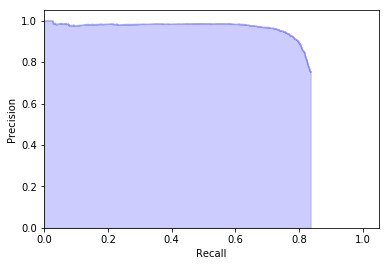

In [26]:
file_prefix = 'SER/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/948_detections_train_ss1_val_ss1_20190908092426.json'

gt_db_path = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiBboxesS01_20190903_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

# Train on SS S1, val on CCT-20

  1%|          | 147/18202 [00:00<00:12, 1467.41it/s]

Running per-object analysis...


100%|██████████| 18202/18202 [00:11<00:00, 1560.32it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18113
Number of ground truth in category 2 is 0

one_class
Number of gt: 18113
Average precision 0.7145319748547024

1
Number of gt: 18113
Average precision 0.7152005263725957

2
Number of gt: 0
Average precision nan

mAP as the average of AP across the 2 categories is 0.3576
Precision at 0.8 recall: 0.4724042379788101


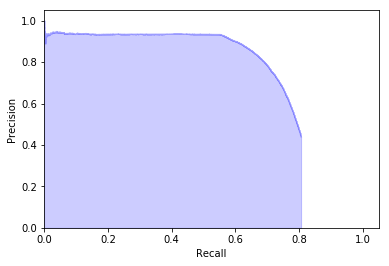

In [27]:
file_prefix = 'cct_images/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/6704_detections_train_ss1_val_cct20_20190908092921.json'

gt_db_path = '/beaver_disk/camtrap/caltech/benchmark/cct-20/caltech-20_bboxes_20190904_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

# Train on CCT-20, val on CCT-20

  1%|          | 165/17918 [00:00<00:10, 1644.61it/s]

Running per-object analysis...


100%|██████████| 17918/17918 [00:11<00:00, 1583.24it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18539
Number of ground truth in category 2 is 0

one_class
Number of gt: 18539
Average precision 0.934790858712975

1
Number of gt: 18539
Average precision 0.9348508911545226

2
Number of gt: 0
Average precision nan

mAP as the average of AP across the 2 categories is 0.4674
Precision at 0.8 recall: 0.9762390574606726


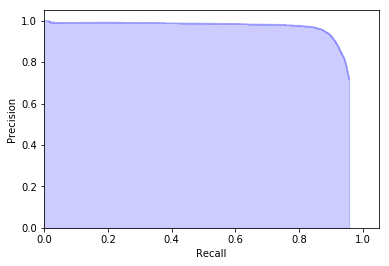

In [28]:
file_prefix = 'cct_images/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/8506_detections_train_cct_20_val_cct20_20190908093026.json'

gt_db_path = '/beaver_disk/camtrap/caltech/benchmark/cct-20/caltech-20_bboxes_20190904_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)

# Train on CCT-20, val on SS S1

  5%|▌         | 141/2725 [00:00<00:01, 1408.14it/s]

Running per-object analysis...


100%|██████████| 2725/2725 [00:01<00:00, 1523.22it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 4208
Number of ground truth in category 2 is 7

one_class
Number of gt: 4215
Average precision 0.7444351997107541

1
Number of gt: 4208
Average precision 0.745673566250197

2
Number of gt: 7
Average precision 0.0

mAP as the average of AP across the 2 categories is 0.3728
Precision at 0.8 recall: 0.0


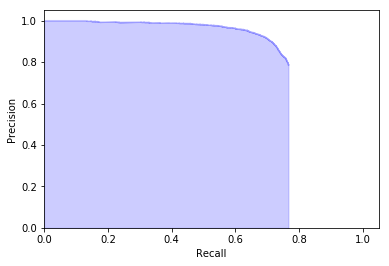

In [29]:
file_prefix = 'SER/'

results_path = '/home/marmot/mnt/ai4edevshare/api_outputs/Benchmark/190904/5618_detections_train_cct_20_val_ss1_20190908093215.json'

gt_db_path = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiBboxesS01_20190903_val.json'

detection_res = make_detection_res(results_path, file_prefix=file_prefix)

gt_indexed = get_gt_db(gt_db_path)

per_image_gts, per_image_detections = get_per_image_gts_and_detections(gt_indexed, detection_res)

per_cat_metrics = detector_eval.compute_precision_recall(per_image_detections, per_image_gts, num_gt_classes, 
                                                         matching_iou_threshold=0.5)

show_metrics(per_cat_metrics)